In [ ]:
!pip install kaggle
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [ ]:
!mkdir /content/drive/MyDrive/dataset_clothes_segmentation/

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aminhd2658","key":"c12f85a30888e55e9944673ceba5eecf"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d rajkumarl/people-clothing-segmentation

 98% 603M/616M [00:06<00:00, 70.3MB/s]
100% 616M/616M [00:06<00:00, 97.4MB/s]


In [ ]:
!unzip people-clothing-segmentation.zip -d drive/MyDrive/dataset_clothes_segmentation

Archive:  people-clothing-segmentation.zip
  inflating: drive/MyDrive/dataset_clothes_segmentation/jpeg_images/IMAGES/img_0001.jpeg  
  inflating: drive/MyDrive/dataset_clothes_segmentation/jpeg_images/IMAGES/img_0002.jpeg  
  inflating: drive/MyDrive/dataset_clothes_segmentation/jpeg_images/IMAGES/img_0003.jpeg  
  inflating: drive/MyDrive/dataset_clothes_segmentation/jpeg_images/IMAGES/img_0004.jpeg  
  inflating: drive/MyDrive/dataset_clothes_segmentation/jpeg_images/IMAGES/img_0005.jpeg  
  inflating: drive/MyDrive/dataset_clothes_segmentation/jpeg_images/IMAGES/img_0006.jpeg  
  inflating: drive/MyDrive/dataset_clothes_segmentation/jpeg_images/IMAGES/img_0007.jpeg  
  inflating: drive/MyDrive/dataset_clothes_segmentation/jpeg_images/IMAGES/img_0008.jpeg  
  inflating: drive/MyDrive/dataset_clothes_segmentation/jpeg_images/IMAGES/img_0009.jpeg  
  inflating: drive/MyDrive/dataset_clothes_segmentation/jpeg_images/IMAGES/img_0010.jpeg  
  inflating: drive/MyDrive/dataset_clothes_segm

In [ ]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from pathlib import Path
import re
from skimage import measure
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import matplotlib as mpl
import tqdm
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [ ]:
images_path = "/content/drive/MyDrive/dataset_clothes_segmentation/png_images/IMAGES"
masks_path = "/content/drive/MyDrive/dataset_clothes_segmentation/png_masks/MASKS"

In [ ]:
OUTPUT_CHANNELS = 9
classes = {'bg':0, 'accessories': 1,  'bag': 2,  'clothes': 3, 'shoes': 4, 'glasses': 5,  'hair': 6,  'hat': 7,  'skin': 8}
convs = {0: 0, 1: 1, 2: 2, 3: 3, 4: 3, 5: 3, 6: 3, 7: 4, 8: 3, 9: 1, 10: 3, 11: 3, 12: 4, 13: 3, 14: 3, 15: 1, 16: 4, 17: 5, 18: 3, 19: 6, 20: 7, 21: 4, 22: 3, 23: 3, 24: 3, 25: 3, 26: 3, 27: 3, 28: 4, 29: 1, 30: 3, 31: 3, 32: 4, 33: 3, 34: 1, 35: 3, 36: 4, 37: 3, 38: 3, 39: 4, 40: 3, 41: 8, 42: 3, 43: 4, 44: 3, 45: 3, 46: 3, 47: 5, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 3, 54: 3, 55: 3, 56: 3, 57: 1, 58: 4}

In [ ]:
def standardize(x):
    x = np.array(x, dtype='float64')
    x -= np.min(x)
    x /= np.percentile(x, 98)
    x[x > 1] = 1
    return x

def preprocessing(img):
    image = np.array(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = np.zeros_like(image)
    image[:,:,0] = gray
    image[:,:,1] = gray
    image[:,:,2] = gray
    image = standardize(image)
    return image

In [ ]:
#Capture training image info as a list
images_paths = []
masks_paths = []

for imgname in os.listdir(images_path):
  images_paths.append(os.path.join(images_path,imgname))

for imgname in os.listdir(masks_path):
  masks_paths.append(os.path.join(masks_path,imgname))

In [ ]:
print(images_paths[:5])

['/content/drive/MyDrive/dataset_clothes_segmentation/png_images/IMAGES/img_0017.png', '/content/drive/MyDrive/dataset_clothes_segmentation/png_images/IMAGES/img_0010.png', '/content/drive/MyDrive/dataset_clothes_segmentation/png_images/IMAGES/img_0002.png', '/content/drive/MyDrive/dataset_clothes_segmentation/png_images/IMAGES/img_0011.png', '/content/drive/MyDrive/dataset_clothes_segmentation/png_images/IMAGES/img_0001.png']


In [ ]:
print(masks_paths[:5])

['/content/drive/MyDrive/dataset_clothes_segmentation/png_masks/MASKS/seg_0240.png', '/content/drive/MyDrive/dataset_clothes_segmentation/png_masks/MASKS/seg_0075.png', '/content/drive/MyDrive/dataset_clothes_segmentation/png_masks/MASKS/seg_0427.png', '/content/drive/MyDrive/dataset_clothes_segmentation/png_masks/MASKS/seg_0816.png', '/content/drive/MyDrive/dataset_clothes_segmentation/png_masks/MASKS/seg_0275.png']


In [ ]:
images_paths.sort()
masks_paths.sort()

In [ ]:
#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes=9 #Number of classes for segmentation

#Capture training image info as a list
train_images = []
train_masks = []

for imgpath in tqdm.tqdm(images_paths):
  img = cv2.imread(imgpath)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  img = preprocessing(img)
  train_images.append(img)

for maskpath in tqdm.tqdm(masks_paths):
  mask0 = cv2.imread(maskpath, 0)
  mask1 = cv2.resize(mask0, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
  for oldnum in range(0,59):
      new_num = convs[oldnum]
      mask1[mask1==oldnum]=new_num
  train_masks.append(mask1)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size = 0.10, shuffle=True, random_state = 1)
print("Class values: ", np.unique(y_train))

100%|██████████| 1000/1000 [00:07<00:00, 135.86it/s]


Class values:  [0 1 2 3 4 5 6 7 8]


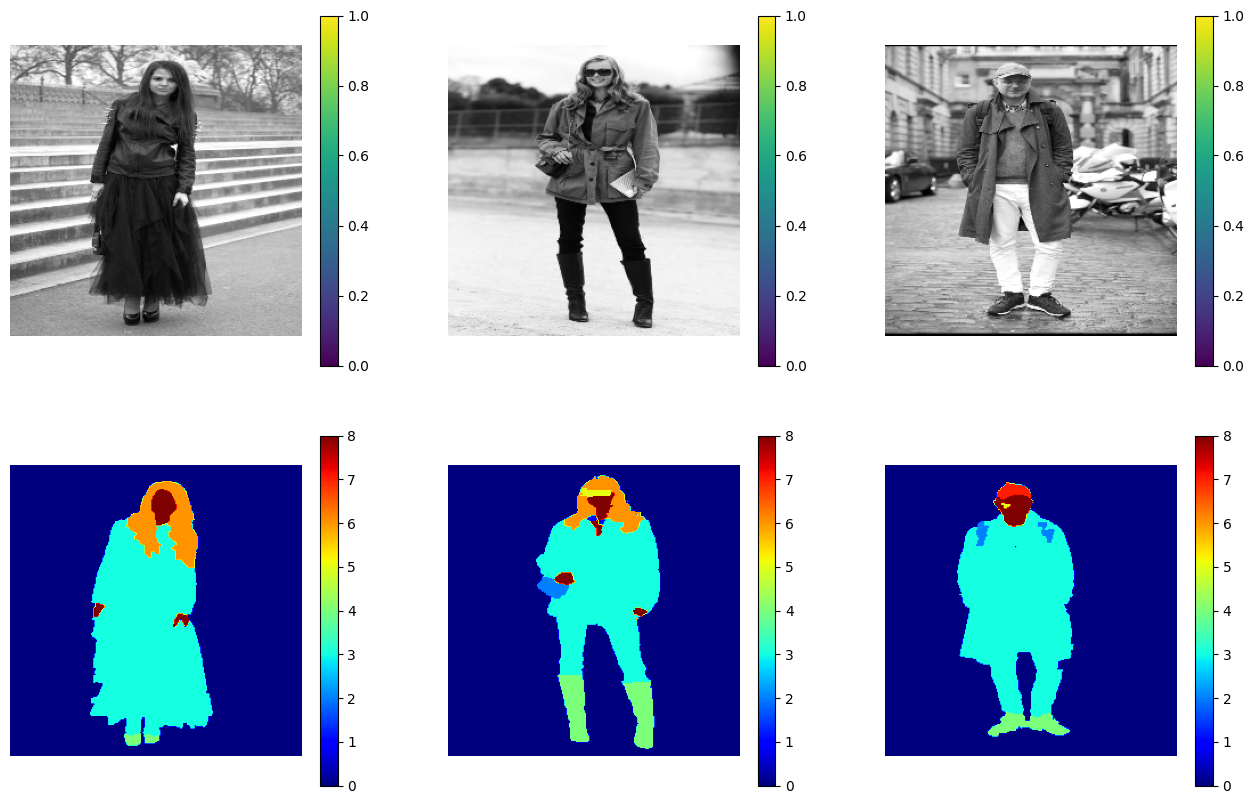

In [ ]:
NORM = mpl.colors.Normalize(vmin=0, vmax=8)

plt.figure(figsize=(16,10))
for i in range(1,4):
    plt.subplot(2,3,i)
    img = train_images[i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')

for i in range(4,7):
    plt.subplot(2,3,i)
    img = np.squeeze(train_masks[i-3])
    plt.imshow(img, cmap='jet', norm=NORM)
    plt.colorbar()
    plt.axis('off')
plt.show()

In [ ]:
def unet_model(output_channels):
    IMG_HEIGHT = X_train.shape[1]
    IMG_WIDTH  = X_train.shape[2]
    IMG_CHANNELS = X_train.shape[3]

    base_model = MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]

    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    inputs = Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = Conv2DTranspose(OUTPUT_CHANNELS, 3, strides=2, padding='same')  #64x64 -> 128x128

    x = last(x)

    return Model(inputs=inputs, outputs=x)


In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(epoch, dataset=None, num=50):
  if dataset:

    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        plt.figure(figsize=(15, 10))
        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(image[0], cmap='gray')
        plt.subplot(232)
        plt.title('Ground Truth')
        plt.imshow(mask[0], cmap='jet')
        plt.subplot(233)
        plt.title('Prediction on test image')
        plt.imshow(create_mask(pred_mask), cmap='jet')

        plt.savefig(f"results/mask_{str(ii)}.png")

        plt.show()
  else:
      fig = plt.figure(figsize=(12, 12))
      fig.suptitle(f"\n Epoch: {str(epoch)}\n", fontsize=16)

      plt.subplot(331)
      plt.title('Testing Image')
      plt.imshow(train_images[num], cmap='gray')
      plt.subplot(332)
      plt.title('Ground Truth')
      plt.imshow(train_masks[num], cmap='jet')
      plt.subplot(333)
      plt.title('Prediction on test image')
      plt.imshow(create_mask(model.predict(train_images[num][tf.newaxis, ...]))[:,:,0], cmap='jet')

      plt.subplot(334)
      plt.imshow(train_images[num+16], cmap='gray')
      plt.subplot(335)
      plt.imshow(train_masks[num+16], cmap='jet')
      plt.subplot(336)
      plt.imshow(create_mask(model.predict(train_images[num+16][tf.newaxis, ...]))[:,:,0], cmap='jet')
      plt.subplot(337)
      plt.imshow(train_images[num+14], cmap='gray')
      plt.subplot(338)
      plt.imshow(train_masks[num+14], cmap='jet')
      plt.subplot(339)
      plt.imshow(create_mask(model.predict(train_images[num+14][tf.newaxis, ...]))[:,:,0], cmap='jet')

      #plt.savefig(f"results/mask_{str(num+100)}_{str(epoch)}.png")

      plt.show()

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


Epoch 1/12
1/1 [==============================] - 0s 298ms/step


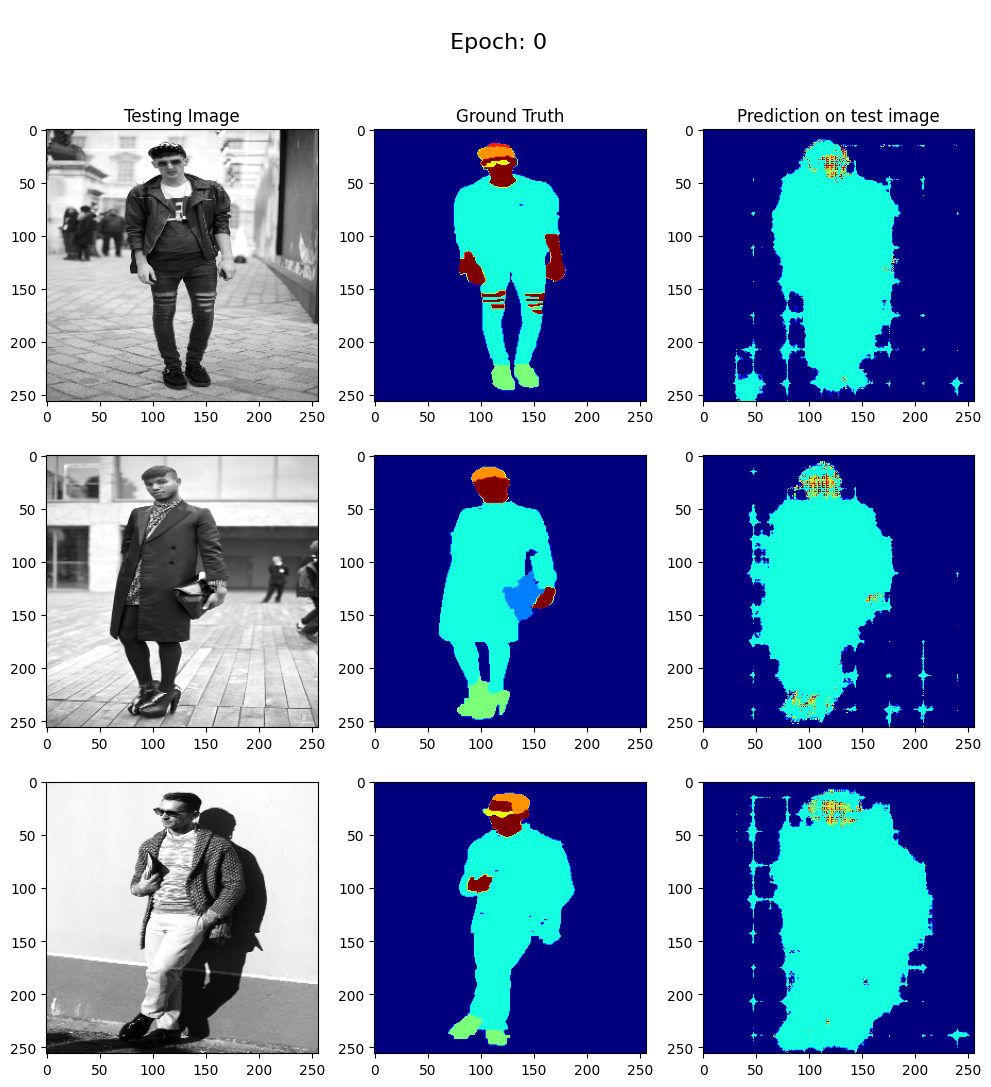


Sample Prediction after epoch 1

57/57 [==============================] - 492s 8s/step - loss: 0.6157 - accuracy: 0.8247 - val_loss: 0.7385 - val_accuracy: 0.8393
Epoch 2/12
1/1 [==============================] - 0s 288ms/step


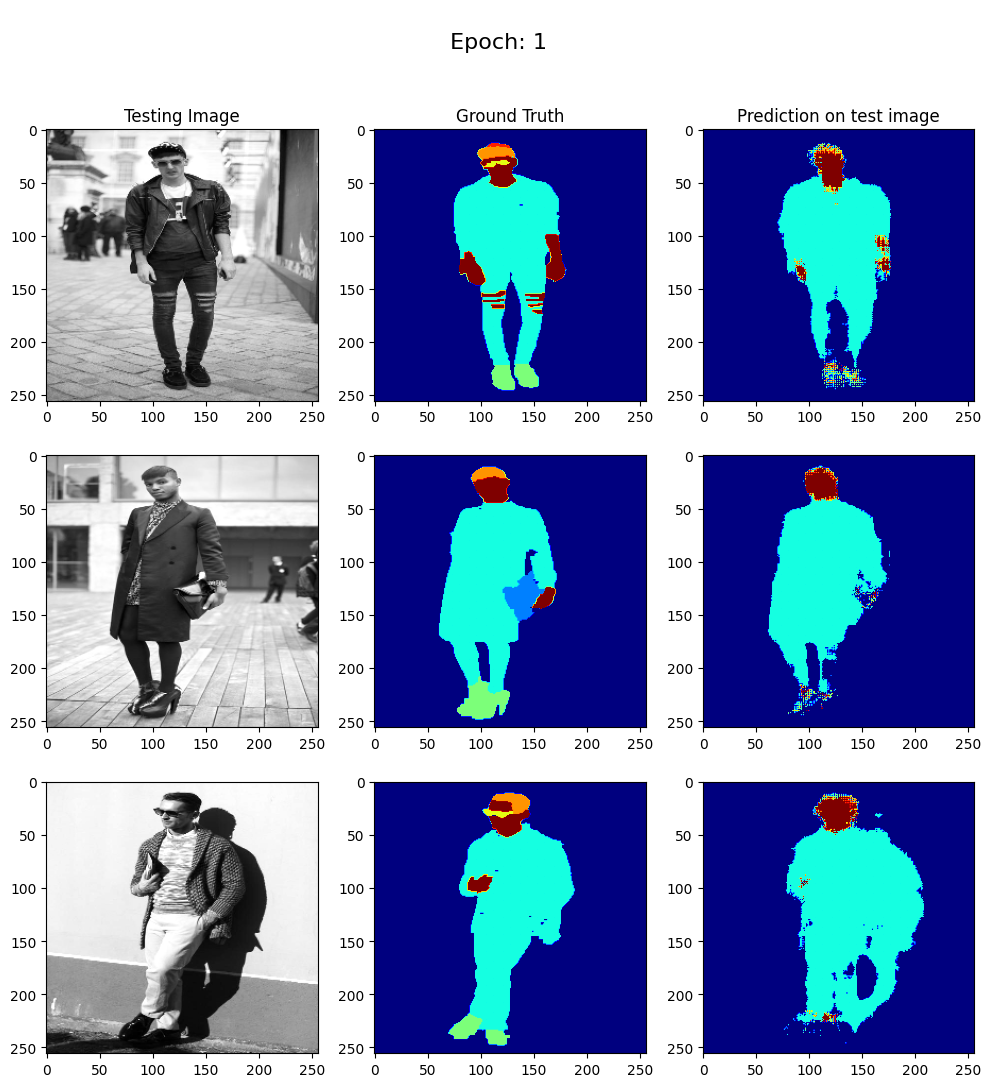


Sample Prediction after epoch 2

57/57 [==============================] - 478s 8s/step - loss: 0.2520 - accuracy: 0.9271 - val_loss: 0.2342 - val_accuracy: 0.9259
Epoch 3/12
1/1 [==============================] - 0s 298ms/step


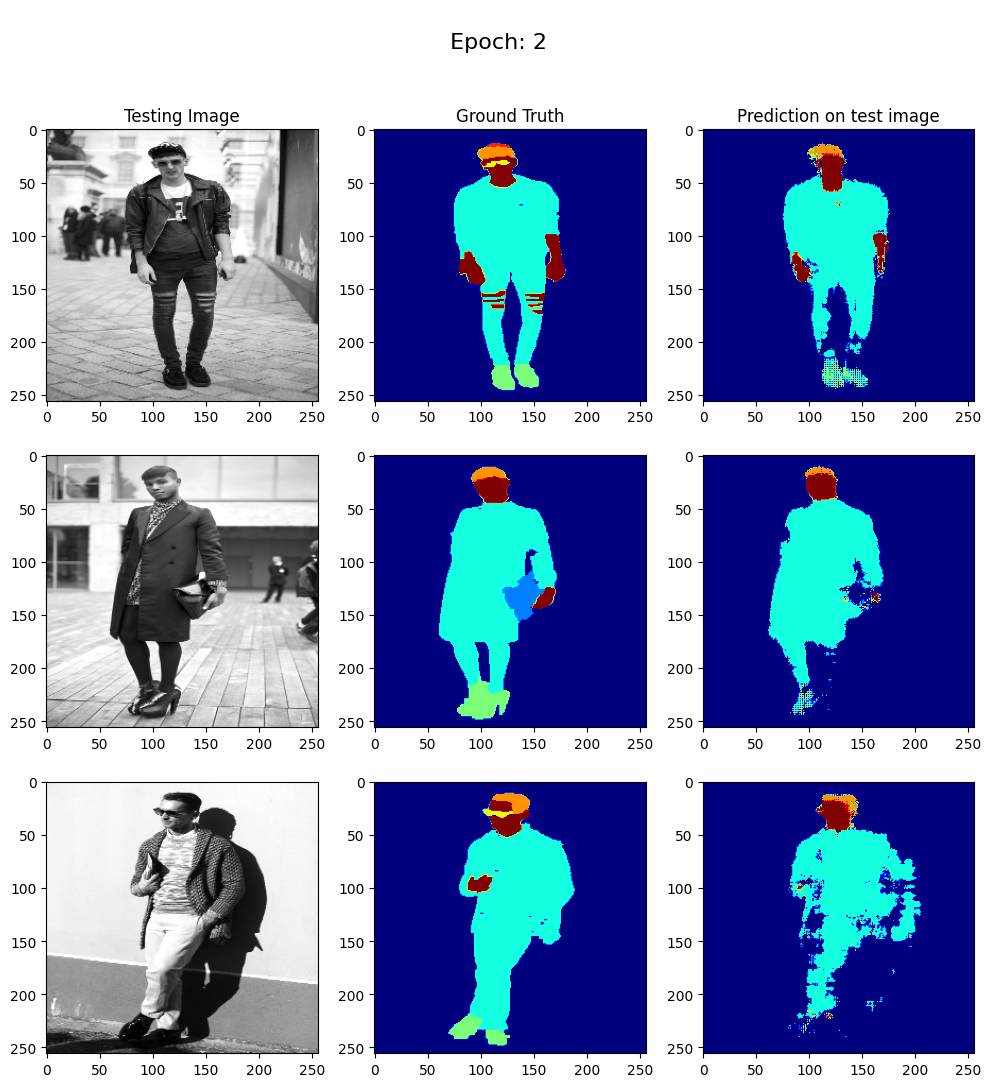


Sample Prediction after epoch 3

57/57 [==============================] - 463s 8s/step - loss: 0.1915 - accuracy: 0.9429 - val_loss: 0.2272 - val_accuracy: 0.9274
Epoch 4/12
1/1 [==============================] - 0s 185ms/step


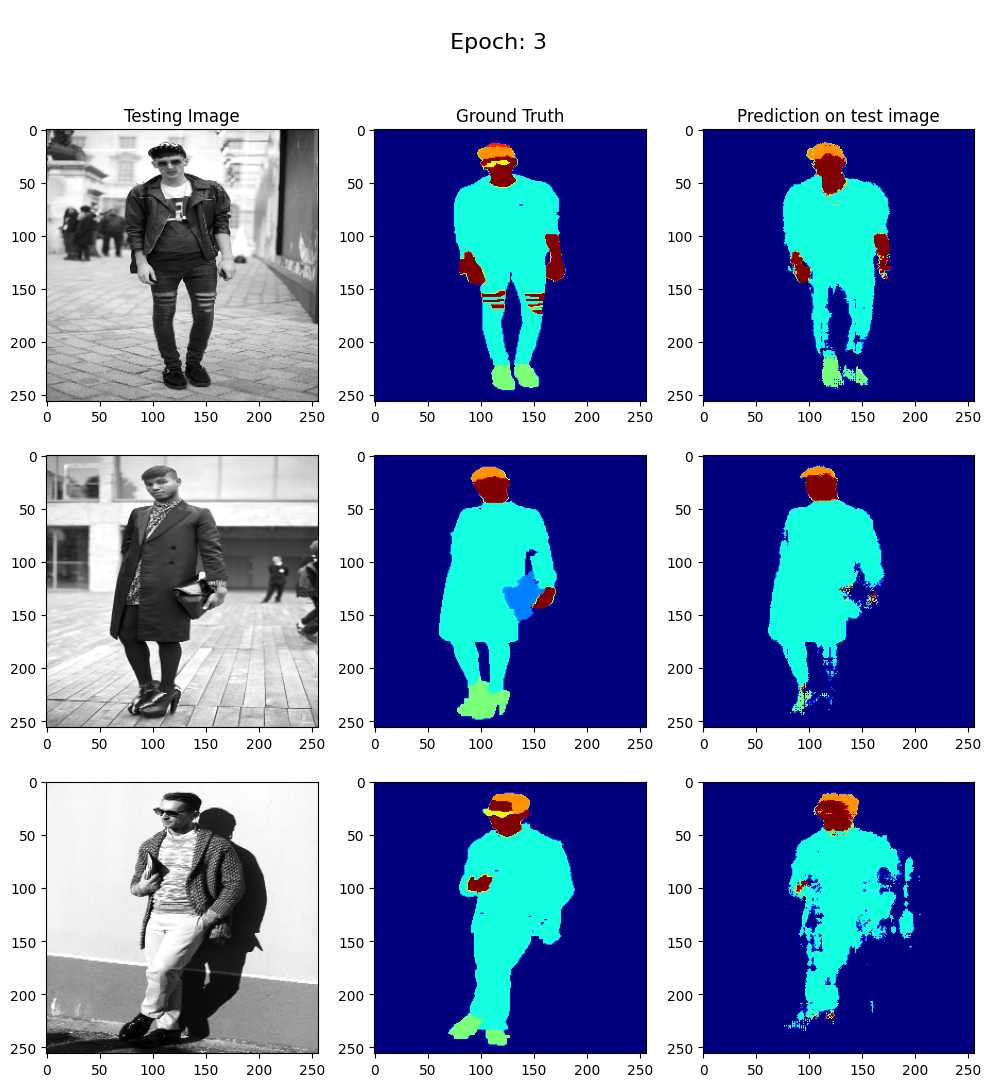


Sample Prediction after epoch 4

57/57 [==============================] - 477s 8s/step - loss: 0.1561 - accuracy: 0.9518 - val_loss: 0.1921 - val_accuracy: 0.9374
Epoch 5/12
1/1 [==============================] - 0s 198ms/step


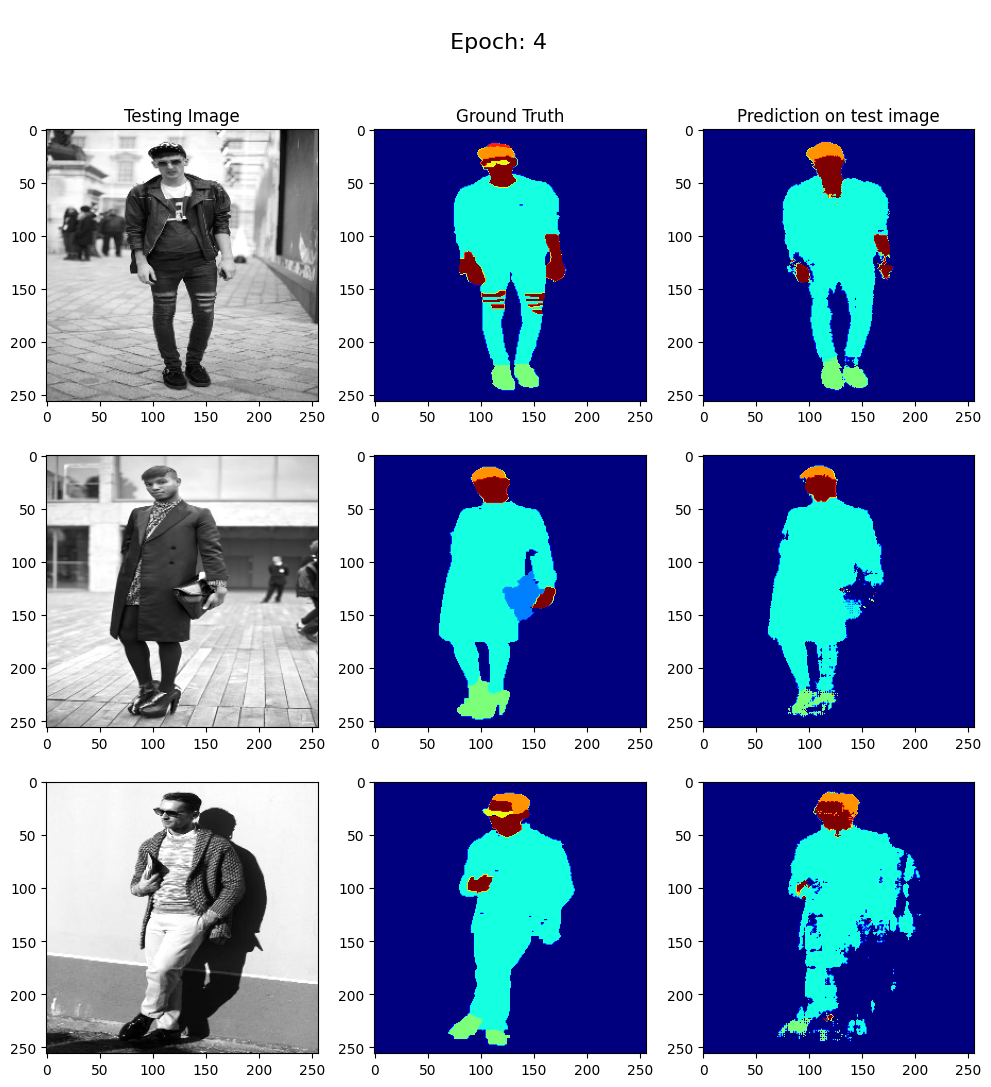


Sample Prediction after epoch 5

57/57 [==============================] - 475s 8s/step - loss: 0.1369 - accuracy: 0.9554 - val_loss: 0.1684 - val_accuracy: 0.9447
Epoch 6/12
1/1 [==============================] - 0s 193ms/step


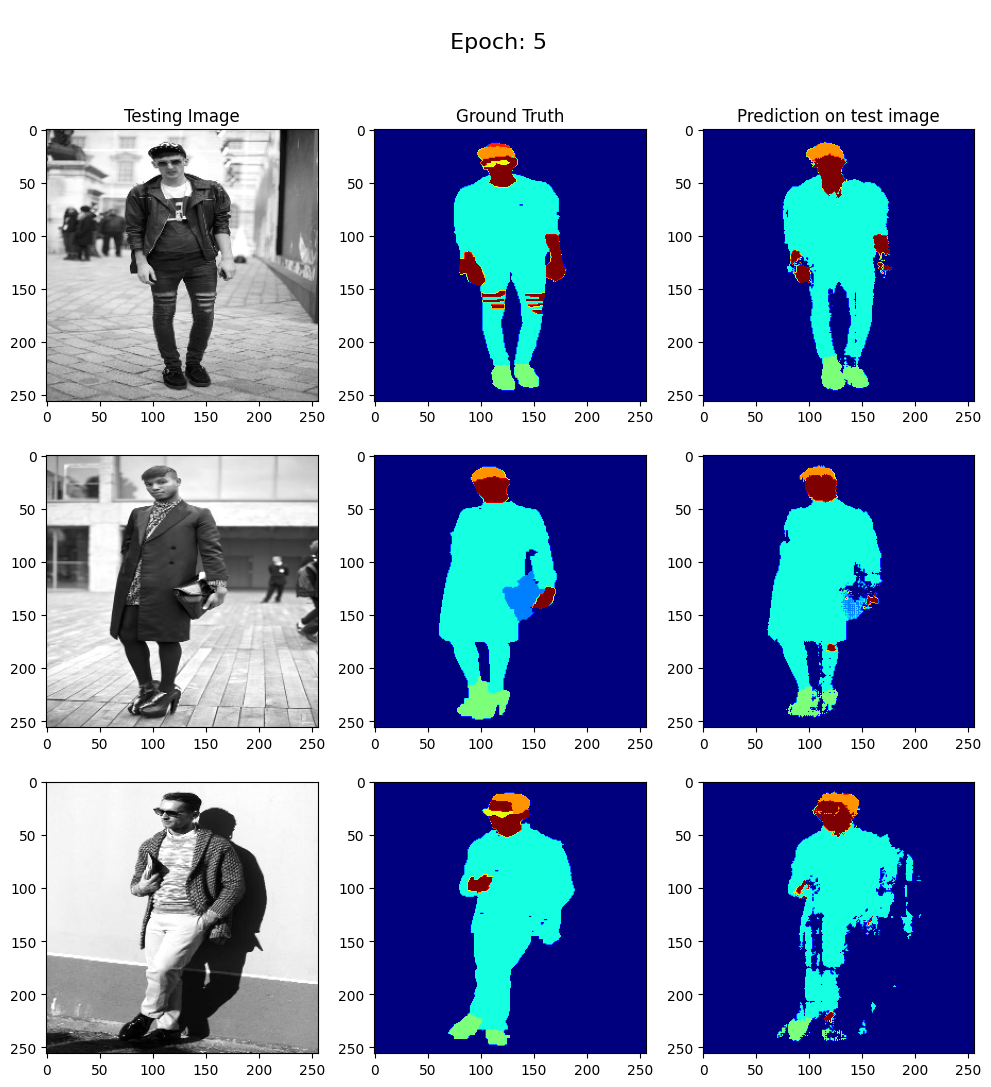


Sample Prediction after epoch 6

57/57 [==============================] - 476s 8s/step - loss: 0.1241 - accuracy: 0.9586 - val_loss: 0.1574 - val_accuracy: 0.9472
Epoch 7/12
1/1 [==============================] - 0s 194ms/step


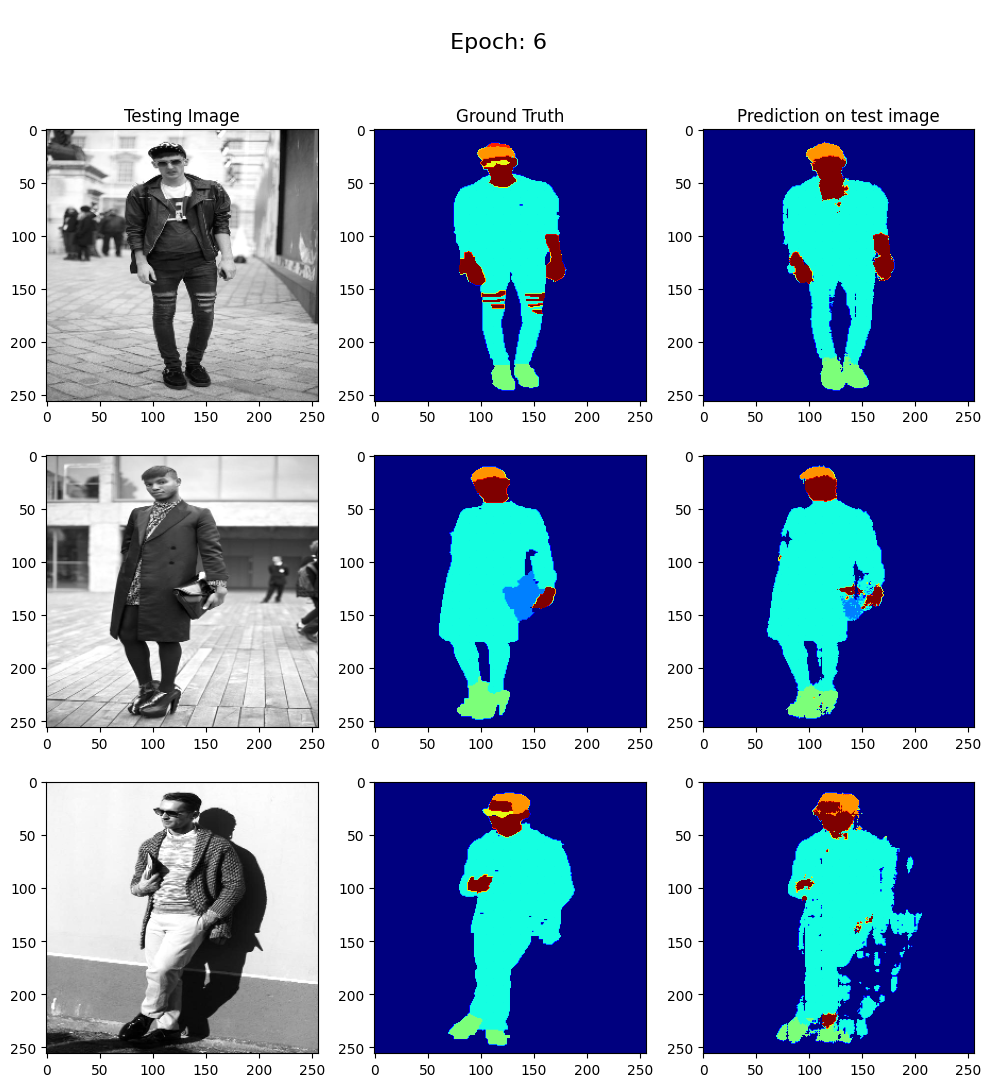


Sample Prediction after epoch 7

57/57 [==============================] - 483s 9s/step - loss: 0.1145 - accuracy: 0.9616 - val_loss: 0.1437 - val_accuracy: 0.9515
Epoch 8/12
1/1 [==============================] - 0s 208ms/step


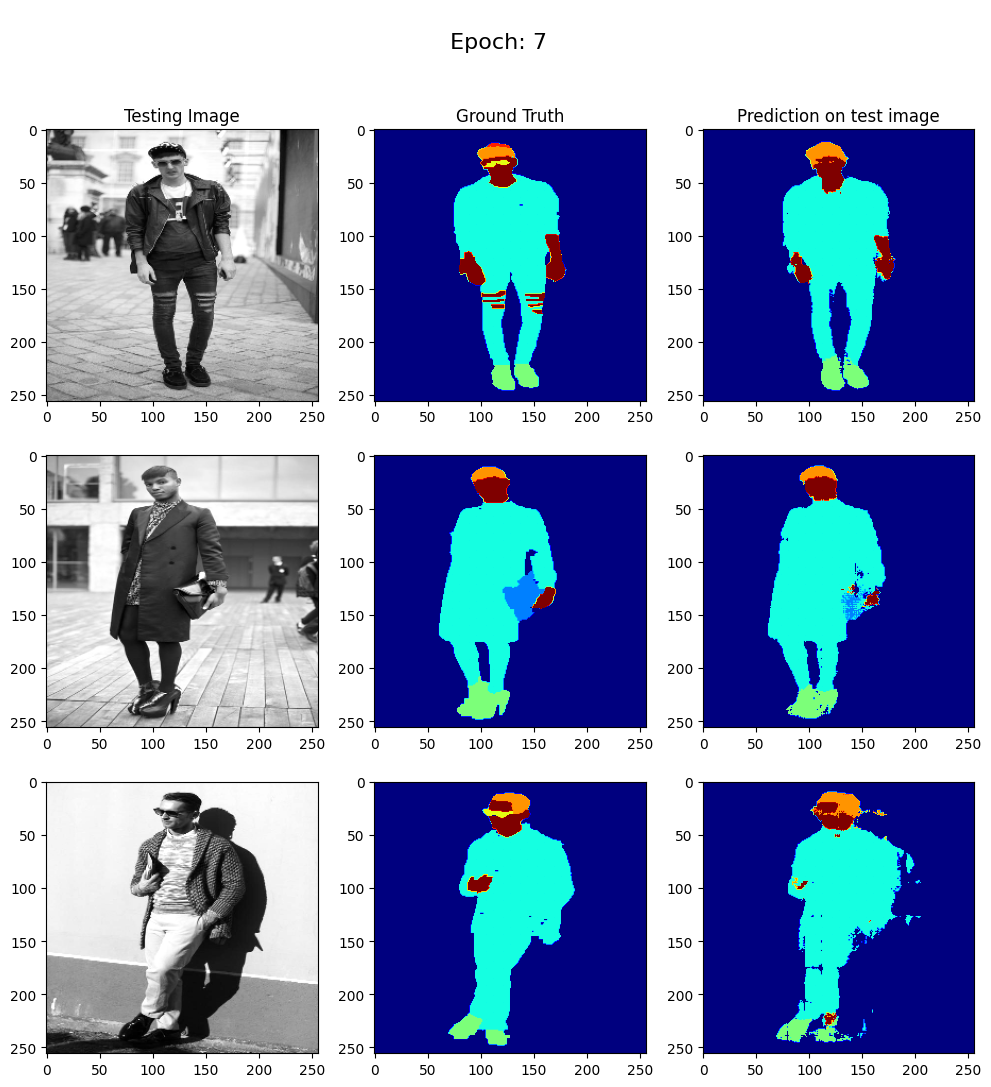


Sample Prediction after epoch 8

57/57 [==============================] - 479s 8s/step - loss: 0.1093 - accuracy: 0.9627 - val_loss: 0.1395 - val_accuracy: 0.9534
Epoch 9/12
1/1 [==============================] - 0s 300ms/step


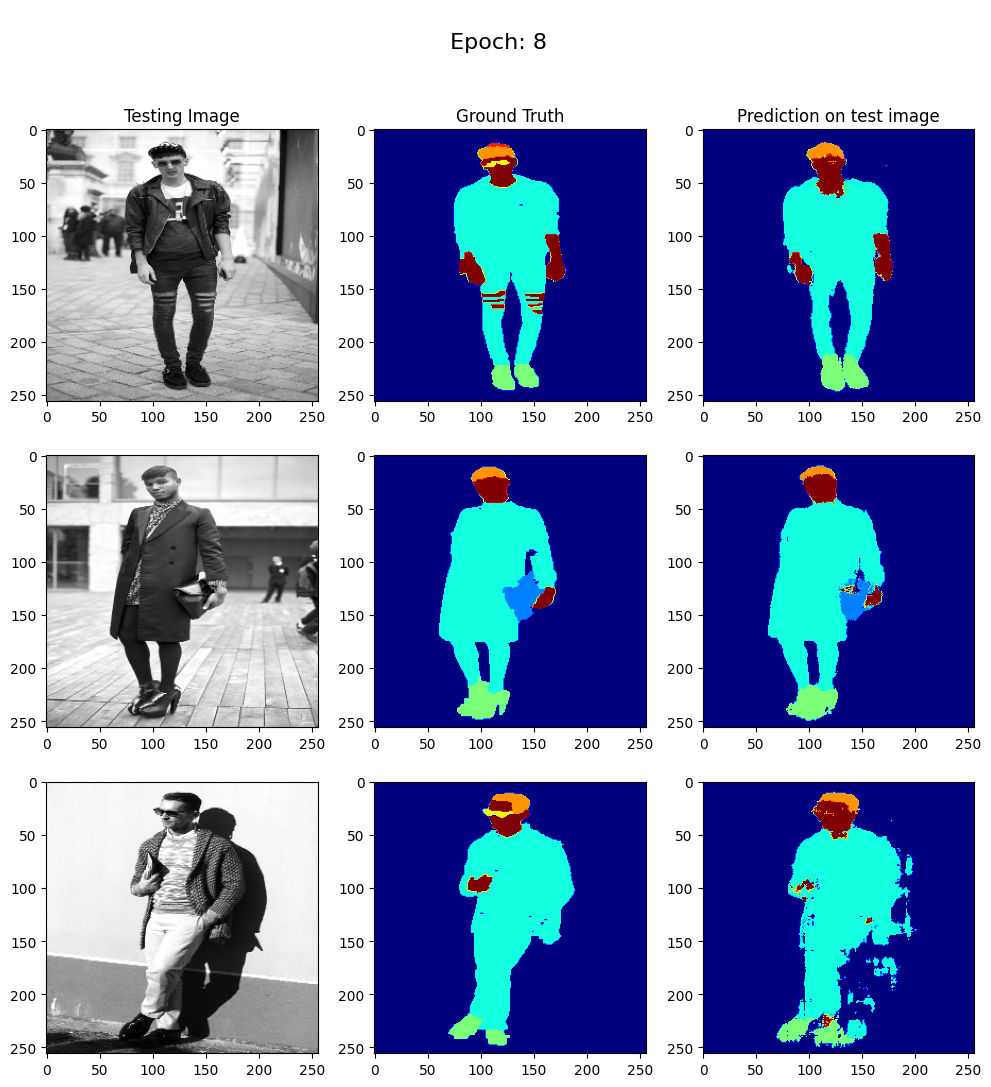


Sample Prediction after epoch 9

57/57 [==============================] - 498s 9s/step - loss: 0.1007 - accuracy: 0.9655 - val_loss: 0.1347 - val_accuracy: 0.9545
Epoch 10/12
1/1 [==============================] - 0s 188ms/step


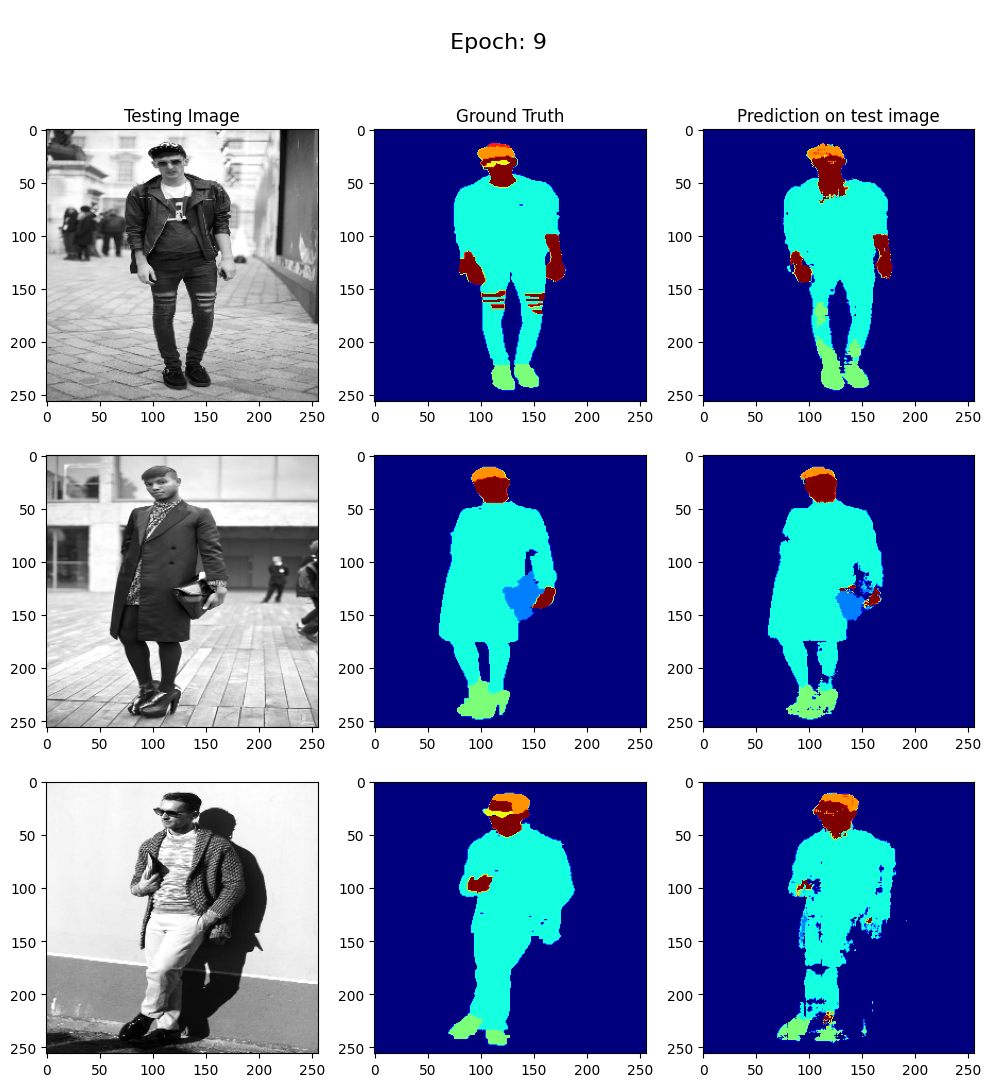


Sample Prediction after epoch 10

57/57 [==============================] - 497s 9s/step - loss: 0.0957 - accuracy: 0.9672 - val_loss: 0.1518 - val_accuracy: 0.9487
Epoch 11/12
1/1 [==============================] - 0s 204ms/step


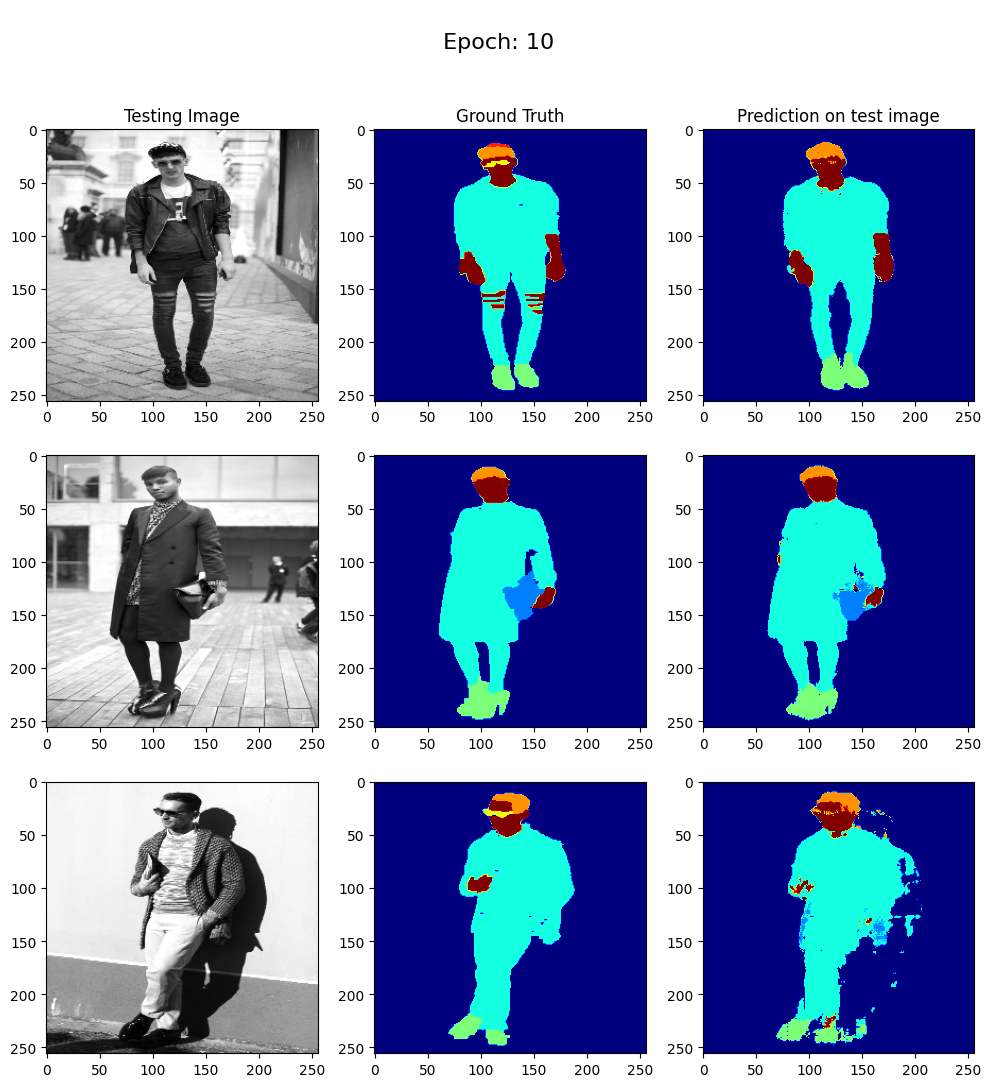


Sample Prediction after epoch 11

57/57 [==============================] - 490s 9s/step - loss: 0.0894 - accuracy: 0.9691 - val_loss: 0.1335 - val_accuracy: 0.9549
Epoch 12/12
1/1 [==============================] - 0s 285ms/step


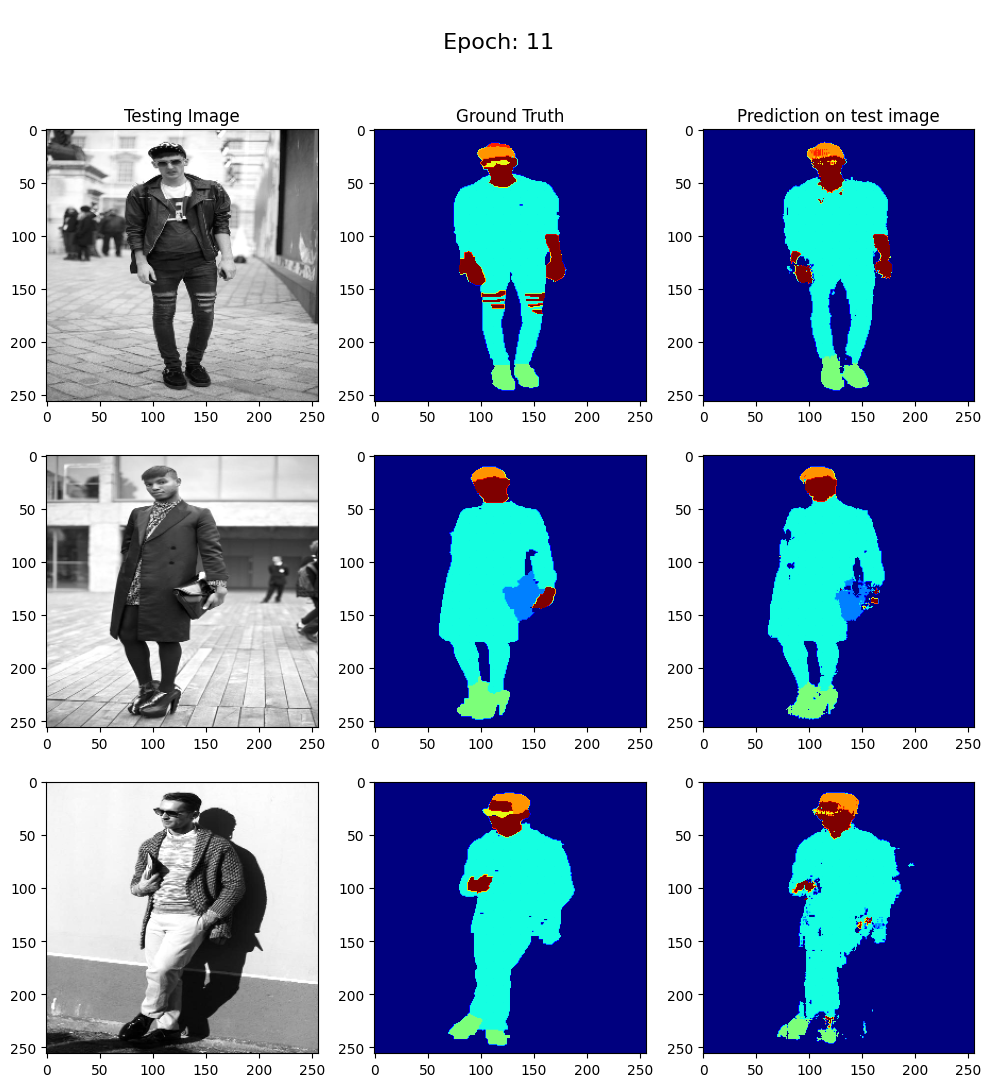


Sample Prediction after epoch 12

57/57 [==============================] - 499s 9s/step - loss: 0.0843 - accuracy: 0.9708 - val_loss: 0.1428 - val_accuracy: 0.9519


In [ ]:
EPOCHS = 12
BATCH_SIZE = 16

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(epoch)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

model_history = model.fit(X_train, y_train,
                          epochs=EPOCHS,
                          batch_size = BATCH_SIZE,
                          verbose=1,
                          validation_data=(X_val, y_val),
                          callbacks=[DisplayCallback()]
                          )

In [ ]:
test_path = "/content/drive/MyDrive/dataset_clothes_segmentation/test_images"

test_paths = []

for imgname in os.listdir(test_path):
  test_paths.append(os.path.join(test_path,imgname))

1/1 [==============================] - 0s 198ms/step


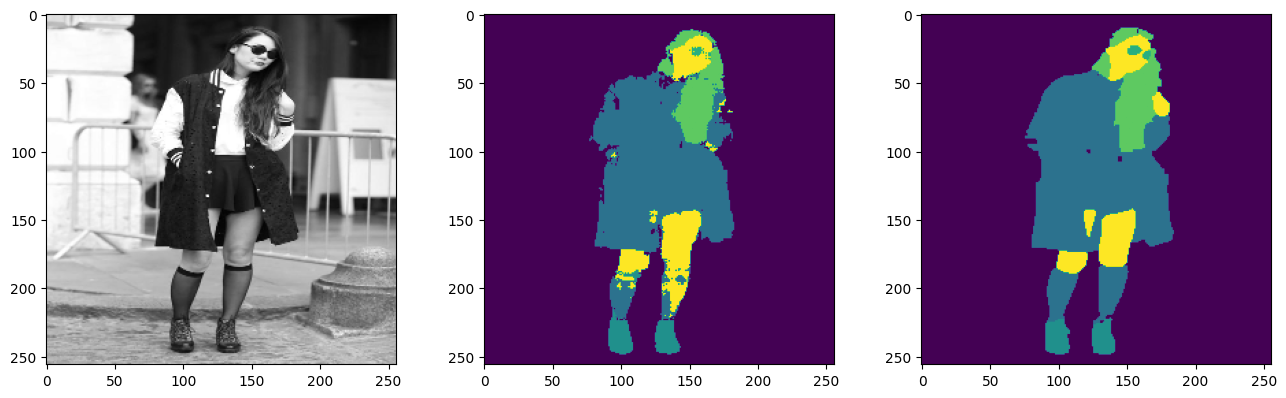

In [ ]:
timgnum = 0
img_num = int(test_paths[timgnum].split("/")[-1].split(".")[0].split("_")[-1])

plt.figure(figsize=(16,10))

plt.subplot(2,3,1)
img = cv2.imread(test_paths[timgnum])
img = cv2.resize(img, (SIZE_Y, SIZE_X))
img = preprocessing(img)
plt.imshow(img)

plt.subplot(2,3,2)
pred = np.array(create_mask(model.predict(img[tf.newaxis, ...])))
plt.imshow(np.squeeze(pred))

plt.subplot(2,3,3)
plt.imshow(train_masks[img_num-1])

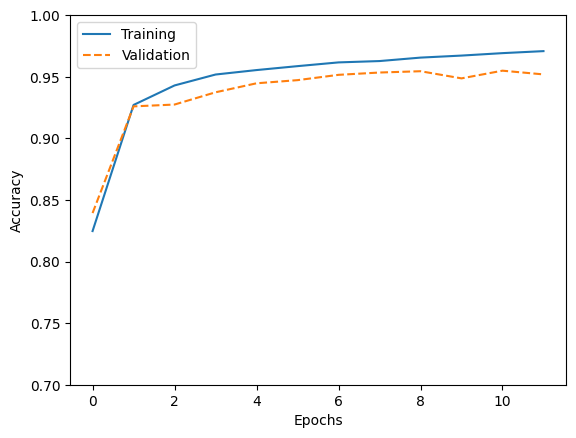

In [ ]:
history_1 = model_history.history
acc=history_1['accuracy']
val_acc = history_1['val_accuracy']

plt.plot(acc[:150], '-', label='Training')
plt.plot(val_acc[:150], '--', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.7,1.0])
plt.legend()
plt.show()

In [ ]:
m = tf.keras.metrics.MeanIoU(num_classes=9)